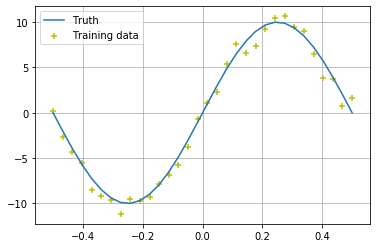

In [1]:
# generate raw data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def f_fun(x):
  return 10 * np.sin(2 * np.pi * x)
num_samples = 32
X = np.linspace(-0.5, 0.5, num_samples).reshape(-1, 1)
y_true = f_fun(X)
y = y_true + np.random.randn(num_samples, 1)

plt.scatter(X, y, marker='+', color='y', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.grid()
plt.legend()

In [2]:
# build BNN model
%tensorflow_version 2.x
from tqdm import tqdm
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

class BNN():

  def __init__(self, prior_sigma_1=1.5, prior_sigma_2=0.1, prior_pi=0.5):
    self.prior_sigma_1 = prior_sigma_1
    self.prior_sigma_2 = prior_sigma_2
    self.prior_pi_1 = prior_pi
    self.prior_pi_2 = 1.0 - prior_pi
    self.kernel_mu_1, self.bias_mu_1, self.kernel_rho_1, self.bias_rho_1 = self.generate_mu_rho([1, 20])
    self.kernel_mu_2, self.bias_mu_2, self.kernel_rho_2, self.bias_rho_2 = self.generate_mu_rho([20, 20])
    self.kernel_mu_3, self.bias_mu_3, self.kernel_rho_3, self.bias_rho_3 = self.generate_mu_rho([20, 1])
    self.trainables = [self.kernel_mu_1, self.bias_mu_1, self.kernel_rho_1, self.bias_rho_1, \
              self.kernel_mu_2, self.bias_mu_2, self.kernel_rho_2, self.bias_rho_2, \
              self.kernel_mu_3, self.bias_mu_3, self.kernel_rho_3, self.bias_rho_3]
    self.optimizer = Adam(0.08)

  def generate_mu_rho(self, shape):
    kernel_mu = tf.Variable(tf.random.truncated_normal(shape, mean=0., stddev=1.))
    bias_mu = tf.Variable(tf.random.truncated_normal(shape[1:], mean=0., stddev=1.))
    kernel_rho = tf.Variable(tf.zeros(shape))
    bias_rho = tf.Variable(tf.zeros(shape[1:]))
    return kernel_mu, bias_mu, kernel_rho, bias_rho

  def __call__(self, inputs):
    self.loss = []
    features_1 = self.dense(inputs, self.kernel_mu_1, self.bias_mu_1, self.kernel_rho_1, self.bias_rho_1)
    features_2 = self.dense(relu(features_1), self.kernel_mu_2, self.bias_mu_2, self.kernel_rho_2, self.bias_rho_2)
    features_3 = self.dense(relu(features_2), self.kernel_mu_3, self.bias_mu_3, self.kernel_rho_3, self.bias_rho_3)
    return features_3
  
  def dense(self, features, kernel_mu, bias_mu, kernel_rho, bias_rho):
    kernel_sigma = tf.math.softplus(kernel_rho)
    kernel = kernel_mu + kernel_sigma * tf.random.normal(kernel_mu.shape)
    self.kl_Qwtheta_Pw(kernel, kernel_mu, kernel_sigma)
    bias_sigma = tf.math.softplus(bias_rho)
    bias = bias_mu + bias_sigma * tf.random.normal(bias_mu.shape)
    self.kl_Qwtheta_Pw(bias, bias_mu, bias_sigma)
    return tf.einsum('ij,jk->ik', features, kernel) + bias
  
  def kl_Qwtheta_Pw(self, w, mu, sigma):
    Qwtheta = tf.math.log(self.gaussian_distribution_density(w, mu, sigma))
    Pw = tf.math.log(self.prior_pi_1 * self.gaussian_distribution_density(w, 0.0, self.prior_sigma_1) + self.prior_pi_2 * self.gaussian_distribution_density(w, 0.0, self.prior_sigma_2))
    self.loss.append(tf.math.reduce_sum(Qwtheta - Pw))

  def gaussian_distribution_density(self, x, mu, sigma):
    return 1.0 / ((2 * np.pi)**0.5 * sigma) * tf.math.exp(-(x - mu)**2 / (2 * sigma**2)) + 1e-30

TensorFlow 2.x selected.


100%|██████████| 2000/2000 [02:29<00:00, 13.40it/s]


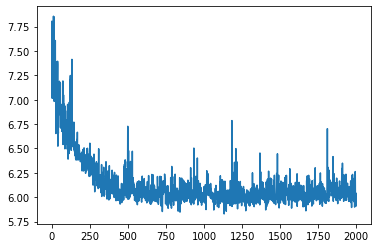

In [3]:
# train model
model = BNN()
loss_list = []
for _ in tqdm(range(2000)):
  with tf.GradientTape() as g:
    y_pred = model(X)
    kl_Qdw = tf.math.reduce_sum(tf.math.log(model.gaussian_distribution_density(y, y_pred, 1.0)))
    model.loss.append(-kl_Qdw)
    loss = tf.reduce_sum(model.loss)
  gradients = g.gradient(loss, model.trainables)
  model.optimizer.apply_gradients(zip(gradients, model.trainables))
  loss_list.append(loss.numpy())
plt.plot(np.log(loss_list))

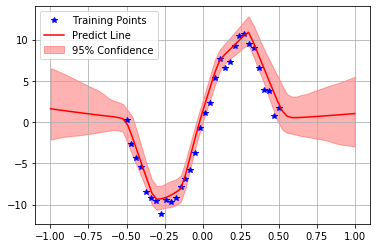

In [4]:
# check model
X_test = np.linspace(-1., 1., num_samples * 2).reshape(-1, 1)
y_test = f_fun(X_test)
y_preds = [model(X_test) for _ in range(300)]
y_preds = np.concatenate(y_preds, axis=1)

plt.plot(X, y, 'b*', label='Training Points')
plt.plot(X_test, np.mean(y_preds, axis=1), 'r-', label='Predict Line')
plt.fill_between(X_test.reshape(-1), np.percentile(y_preds, 2.5, axis=1), np.percentile(y_preds, 97.5, axis=1), color='r', alpha=0.3, label='95% Confidence')
plt.grid()
plt.legend()